# Liberalised Power Markets — Bonus Assignment

Place CSV files in a folder named `Data/` next to this notebook.

In [1]:
import sys
!{sys.executable} -m pip install pulp


In [2]:
# Imports & setup
import os
import math
import shutil
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp
import networkx as nx

def read_input_data(data_dir="Data"):
    nodes = 5
    demand_data = np.zeros((nodes, 24, 4, 3), dtype=float)          # Dimensions: (node, hour, season, scenario)
    wind_data   = np.zeros((nodes, 24, 4, 3), dtype=float)
    node_labels   = ["N1", "N2", "N3", "N4", "N5"]                  # Header for nodes
    season_labels = ["Winter", "Spring", "Summer", "Autumn"]        # Header for seasons
    old_cwd = os.getcwd()
    os.makedirs(data_dir, exist_ok=True)
    try:
        os.chdir(data_dir)
        for i, nlab in enumerate(node_labels):                      # Nodes
            for j, slab in enumerate(season_labels):                # Seasons
                df_d = pd.read_csv(f"D_{nlab}_{slab}.csv")
                df_w = pd.read_csv(f"W_{nlab}_{slab}.csv")
                demand_data[i, :, j, 0] = df_d["Min"].values
                demand_data[i, :, j, 1] = df_d["Mean"].values
                demand_data[i, :, j, 2] = df_d["Max"].values
                wind_data[i, :, j, 0]   = df_w["Min"].values
                wind_data[i, :, j, 1]   = df_w["Mean"].values
                wind_data[i, :, j, 2]   = df_w["Max"].values
    finally:
        os.chdir(old_cwd)
    return demand_data, wind_data


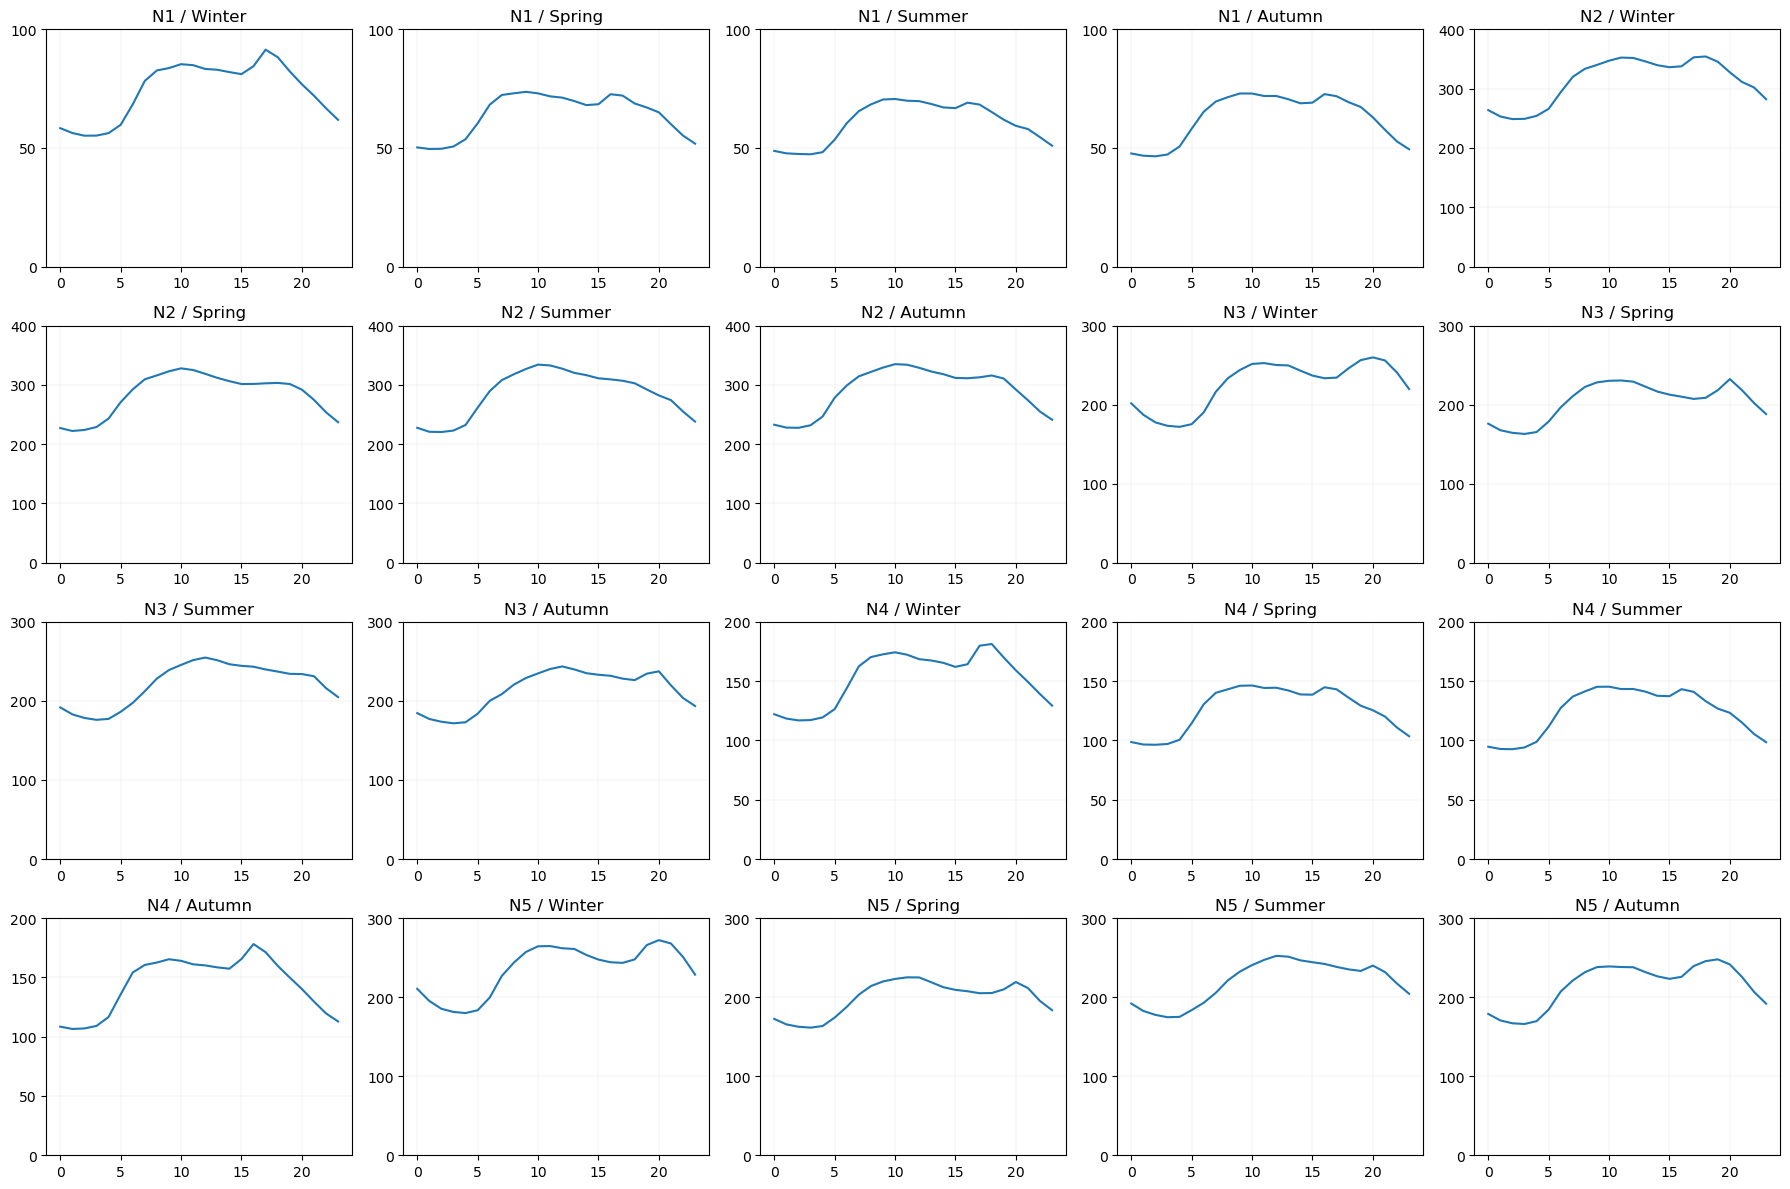

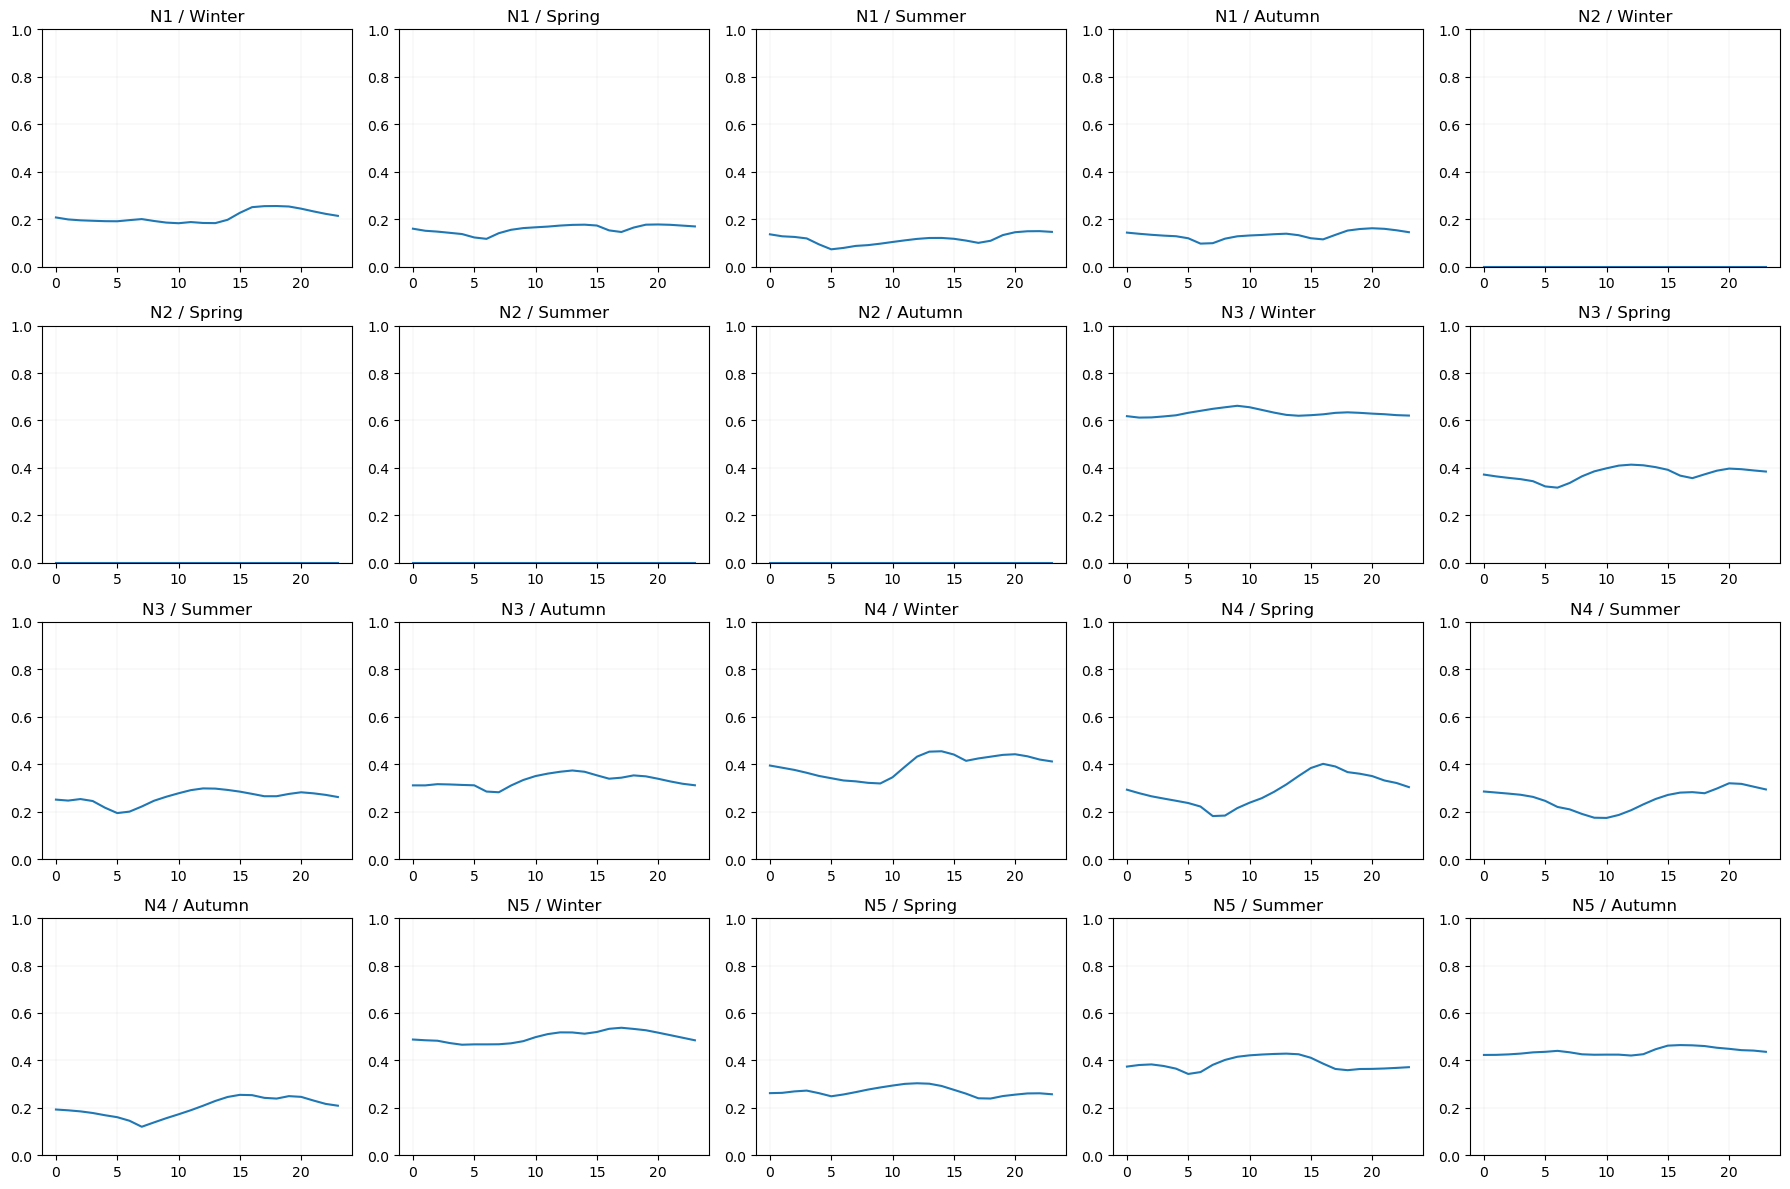

In [3]:
# Load & preprocess deterministic data
max_load = np.array([100, 400, 300, 200, 300], dtype=float)         # The demand data is originally normalised based on a maximum load (in MW) for the location. 
demand_raw, wind_raw = read_input_data("Data")
D = np.zeros((5, 24, 4))        # Create the demand matrix for the deterministic case; dimensions: (node, hour, season)
W = np.zeros((5, 24, 4))        # Create the wind availability factor matrix for the deterministic case
for i in range(5):
    for j in range(4):
        ## The demand considered is equal to the normalised demand of the node times its maximum load.
        D[i, :, j] = max_load[i] * demand_raw[i, :, j, 1]
        
        ## Wind availability is a value ranging from 0 to 1 denoting how much of the 
        ## available generation capacity can be used in each node per hour per season
        W[i, :, j] = wind_raw[i, :, j, 1]

# Quick plots
fig, axes = plt.subplots(4, 5, figsize=(18, 12)); axes = axes.ravel()
node_labels   = ["N1", "N2", "N3", "N4", "N5"]
season_labels = ["Winter", "Spring", "Summer", "Autumn"]
idx = 0
for i, nlab in enumerate(node_labels):
    for j, slab in enumerate(season_labels):
        ax = axes[idx]; ax.plot(D[i, :, j]); ax.set_title(f"{nlab} / {slab}")
        ax.set_ylim(0, max_load[i]); ax.grid(linewidth=0.1)
        ax.set_yticks(np.arange(0, max_load[i] + 1e-9, 100 if i in [1,2,4] else 50)); idx += 1
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(4, 5, figsize=(18, 12)); axes = axes.ravel(); idx = 0
for i, nlab in enumerate(node_labels):
    for j, slab in enumerate(season_labels):
        ax = axes[idx]; ax.plot(W[i, :, j]); ax.set_title(f"{nlab} / {slab}")
        ax.set_ylim(0, 1); ax.grid(linewidth=0.1); idx += 1
plt.tight_layout(); plt.show()


In [4]:
# Sets & parameters
nodes = 5                       # Number of nodes considered      
N = list(range(1, nodes+1))     # Nodes set
H = list(range(1, 24+1))        # Hours in the day {1,...,24} (time periods in the model in each representative day)
S = list(range(1, 4+1))         # Seasons: 1 = "Winter",2 = "Spring",3 = "Summer",4 = "Autumn"
T = list(range(1, 5+1))         # Generation Technologies: # 1: Wind, 2: Nuclear; 3: Coal, 4: Gas OCGT, 5: Gas CCGT
L = list(combinations(range(1, nodes+1), 2))    # Lines set (list of tuples [i,j]) - generate all combinations (i,j) once
SS = [92, 91, 91, 91]           # Number of days in each season (used to calculate costs correctly)
season_days = lambda s: SS[s-1]
line_index = {l: i for i, l in enumerate(L)}

## Parameters (energy generation)

KI = np.array([1500.0, 3000.0, 1000.0, 500.0, 800.0])       # Generation investment cost [k€/MW]
LT = np.array([25, 30, 40, 40, 50])                         # Generation technology lifetime [years]
K  = KI * 0.05 / (1 - (1.05 ** (-LT)))                      # Annualized generation investment cost (interest rate of 5% pa)[k€/MW]
KA = np.array([60.0, 50.0, 48.0, 10.0, 16.0])               # Generation maintenance cost [k€/MW]
CO = np.array([0.1, 6.2, 13.0, 23.0, 20.0]) / 1000          # Generation operational cost [k€/MWh]
CS = 1.0        # Shedding cost [k€/MWh]
ShC = 0.1       # Shedding limit [% of demand]
RES = 0.25      # Mininum renewable energy share (for all nodes)

## Existing generation capacity (t: technologies x n: nodes); N1 and N2 start with initial nuclear capacity.
GCN = np.array([
    [0, 0, 0, 0, 0],
    [30, 60, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
], dtype=float)

## Parameters (transmission)

KIT = 0.5                                                   # Line investment cost (also per km) [k€/MW.km]
dist = np.array([200, 400, 300,                             # Length in km of each line (i.e, [1,2], [1,3]..., [4,5], in order) 
                800, 200, 700,                              # (see L defined above for the full ordering if necessary)
                500, 750, 350, 180], dtype=float)
LT_T = 40                                                   # Transmission line lifetime [years]
KT_per_line = KIT * dist * 0.05 / (1 - (1.05 ** (-LT_T)))   # Annualized transmission investment cost (interest rate of 5% pa)[k€/MW]  
KAT = 0.01                                                  # Transmission maintenance cost [k€/MW] 
COT = 1e-4                                                  # Transmission operational cost [k€/MWh]

def D_val(n,h,s): return D[n-1, h-1, s-1]
def W_val(n,h,s): return W[n-1, h-1, s-1]


## Task 1
The deterministic model

In [5]:
import pulp

# IMPORTANT INDEXING NOTE (READ CAREFULLY!)
# -----------------------------------------
# PuLP variables (p, p_max, q, f, ...) are NOT NumPy arrays.
# They are dictionaries indexed by the ELEMENTS of the sets T, N, H, S.
#
# Example:
#   p_max[t][n]     uses t ∈ {1,2,3,4,5} and n ∈ {1,...,5}
#
# In contrast, data like GCN, D, W are stored as NumPy arrays,
# which use 0-based indexing.
#
# Example:
#   GCN[t-1, n-1]   corresponds to technology t at node n
#
# Therefore, when combining DATA with DECISION VARIABLES:
#
# Correct indexing:
#   x[t][n] <= data_array[t-1, n-1] + y[t][n]
#
# WRONG indexing:
#   x[t][n] <= data_array[t, n] + y[t][n]
#
# Rule of thumb:
#   - PuLP variables  → use set indices (t, n, h, s)
#   - NumPy arrays   → use shifted indices (t-1, n-1, h-1, s-1)
#
# If you mix this up, your model will still run,
# but it will represent the WRONG mathematical problem.


# Deterministic model (PuLP)
def build_det_model_pulp():
    m = pulp.LpProblem("GTEP_Deterministic", pulp.LpMinimize)
    p     = pulp.LpVariable.dicts("p",     (T, H, N, S), lowBound=0)        # Generation level in each hour by t [MWh]
    p_max = pulp.LpVariable.dicts("p_max", (T, N),        lowBound=0)       # Additional generation capac. of t [MW]
    q     = pulp.LpVariable.dicts("q",     (H, N, S),     lowBound=0)       # Energy shedding in h [MWh]
    f     = pulp.LpVariable.dicts("f",     (H, L, S),     lowBound=None)    # Transmission flow in each hour by t [MWh]
    f_abs = pulp.LpVariable.dicts("f_abs", (H, L, S),     lowBound=0)       # Auxiliary variable for calculating |f[h,l,s]|
    f_max = pulp.LpVariable.dicts("f_max", (L,),          lowBound=0)       # Additional transmission capac. of l [MW]

    ## Objective function: total system cost comprised of:
    ## 1. Generation capacity investment costs (fixed and variable)
    ## 2. Generation operational costs
    ## 3. Transmission capacity investment costs
    ## 4. Transmission operational costs
    ## 5. Shedding costs

     # 1) Generation investment (annualised capex) + fixed O&M on built capacity
    gen_invest = pulp.lpSum(
        (K[t-1] + KA[t-1]) * p_max[t][n]
        for t in T for n in N
    )

    # 2) Transmission investment (annualised) + fixed O&M
    trans_invest = pulp.lpSum(
        (KT_per_line[line_index[l]] + KAT) * f_max[l]
        for l in L
    )

    # 3) Generation operational cost (weighted by number of days represented by each season)
    gen_oper = pulp.lpSum(
        season_days(s) * CO[t-1] * p[t][h][n][s]
        for t in T for h in H for n in N for s in S
    )

    # 4) Transmission operational cost on |flow|
    trans_oper = pulp.lpSum(
        season_days(s) * COT * f_abs[h][l][s]
        for h in H for l in L for s in S
    )

    # 5) Shedding cost
    shed_cost = pulp.lpSum(
        season_days(s) * CS * q[h][n][s]
        for h in H for n in N for s in S
    )

    m += gen_invest + trans_invest + gen_oper + trans_oper + shed_cost


    ## Constraints
    # Helper: incidence sign for line l=(i,j)
    # Convention: f[h,(i,j),s] > 0 means flow from i -> j
    def inc(n, l):
        i, j = l
        if n == i:
            return -1
        elif n == j:
            return +1
        else:
            return 0


    # 1) Energy balance per node/hour/season:
    # sum_t p + net_inflow = demand - shedding
    for h in H:
        for n in N:
            for s in S:
                m += (
                    pulp.lpSum(p[t][h][n][s] for t in T)
                    + pulp.lpSum(inc(n, l) * f[h][l][s] for l in L)
                    == D_val(n, h, s) - q[h][n][s]
                ), f"bal_{h}_{n}_{s}"


    # 2) Wind generation availability constraint:
    # p_wind <= (existing_wind + new_wind) * availability
    for h in H:
        for n in N:
            for s in S:
                m += (
                    p[1][h][n][s]
                    <= (GCN[0, n-1] + p_max[1][n]) * W_val(n, h, s)
                )


    # 3) Non-renewable generation capacity constraints:
    # p_t <= existing_t + new_t   for t = 2..5
    for t in [2, 3, 4, 5]:
        for h in H:
            for n in N:
                for s in S:
                    m += (
                        p[t][h][n][s]
                        <= GCN[t-1, n-1] + p_max[t][n]
                    )


    # 4) Minimum renewable energy share (system-wide):
    # total_wind >= RES * total_generation
    total_ren = pulp.lpSum(
        season_days(s) * p[1][h][n][s]
        for h in H for n in N for s in S
    )

    total_gen = pulp.lpSum(
        season_days(s) * pulp.lpSum(p[t][h][n][s] for t in T)
        for h in H for n in N for s in S
    )

    m += total_ren >= RES * total_gen


    # 5) Shedding limit: q <= ShC * demand
    for h in H:
        for n in N:
            for s in S:
                m += q[h][n][s] <= ShC * D_val(n, h, s)


    # 6) Transmission capacity bounds: -cap <= f <= cap
    # Here cap = f_max[l] (no existing capacity given in skeleton)
    # 7) Linearisation for absolute value: f_abs >= f and f_abs >= -f
    for h in H:
        for l in L:
            for s in S:
                m += f[h][l][s] <= f_max[l]
                m += f[h][l][s] >= -f_max[l]
                m += f_abs[h][l][s] >= f[h][l][s]
                m += f_abs[h][l][s] >= -f[h][l][s]


    return m, (p, p_max, q, f, f_abs, f_max)

m_det, (p, p_max, q, f, f_abs, f_max) = build_det_model_pulp()

# Use CBC as LP solver to get duals
solver = pulp.PULP_CBC_CMD(msg=False, mip=False)
m_det.solve(solver)


lam = np.zeros((len(H), len(N), len(S)))
for h in H:
    for n in N:
        for s in S:
            cname = f"bal_{h}_{n}_{s}"
            lam[h-1, n-1, s-1] = m_det.constraints[cname].pi

sol_p_max_det = np.zeros((len(T), len(N)))
for t in T:
    for n in N:
        sol_p_max_det[t-1, n-1] = pulp.value(p_max[t][n])

sol_f_max_det = np.zeros(len(L))
for i,l in enumerate(L):
    sol_f_max_det[i] = pulp.value(f_max[l])
    
sol_p = np.zeros((len(T), len(H), len(N), len(S)))
for ti,t in enumerate(T):
    for hi,h in enumerate(H):
        for ni,n in enumerate(N):
            for si,s in enumerate(S):
                sol_p[ti,hi,ni,si] = pulp.value(p[t][h][n][s])


dual_vals = lam.flatten() 

mean_price = np.mean(dual_vals)
std_price  = np.std(dual_vals)
max_price  = np.max(dual_vals)
min_price  = np.min(dual_vals)  

## Analyzing the solution of the deterministic model

Here are some examples of questions that can be answered with information from the optimisation model.

1.a) "What was the generation capacity per technology per node installed? What was the transmission capacity installed?"

In [6]:
print("Capacities installed (Tech x Node):")
print(np.round(sol_p_max_det, 2))
print("\nTransmission capacities (per line):")
print(np.round(sol_f_max_det, 2))

Capacities installed (Tech x Node):
[[  0.     0.   130.46   0.   451.85]
 [  0.     0.     0.     0.     0.  ]
 [ 28.34 194.46 129.05 121.02  12.05]
 [ 19.95  87.17  47.3   36.86  49.47]
 [  0.     0.     0.     0.     0.  ]]

Transmission capacities (per line):
[ 3.12  7.64  2.38 -0.   14.27  0.   -0.    0.   17.72 24.37]


1.b) "What is the average price for electricity?

In [7]:
print("\nHourly price statistics:")
print(f"- Mean price per MWh: {mean_price:.2f}")
print(f"- Standard deviation: {std_price:.2f}")
print(f"- Max price per MWh: {max_price:.2f}")
print(f"- Min price per MWh: {min_price:.2f}")


Hourly price statistics:
- Mean price per MWh: 2.82
- Standard deviation: 2.44
- Max price per MWh: 21.46
- Min price per MWh: 1.70


1.c) "Trade profile"

In [8]:
sol_f = np.zeros((len(H), len(L), len(S)))
for h in H:
    for li,l in enumerate(L):
        for s in S:
            sol_f[h-1, li, s-1] = pulp.value(f[h][l][s])
            
trade_matrix = np.round(sol_f.sum(axis=0), 2)   

print("\nTrade profiles per season (Lines x Seasons):")
print(trade_matrix)
season_labels = [f"S{s}" for s in S]
line_labels   = [f"L{l}" for l in range(1, len(L)+1)]

df_trade = pd.DataFrame(trade_matrix, index=line_labels, columns=season_labels)

print("\nTrade profile table:")
print(df_trade)


Trade profiles per season (Lines x Seasons):
[[ -11.41   -3.12    1.22    0.48]
 [ -58.06   37.53  143.83   22.13]
 [ -12.66   16.25    2.32    9.58]
 [  -0.      0.      0.      0.  ]
 [ -97.75  102.71  264.46   79.7 ]
 [  -0.      0.     -0.      0.  ]
 [   0.     -0.     -0.      0.  ]
 [   0.      0.      0.      0.  ]
 [-113.79  241.53 -138.55 -141.32]
 [-268.79  420.19  197.35 -145.31]]

Trade profile table:
         S1      S2      S3      S4
L1   -11.41   -3.12    1.22    0.48
L2   -58.06   37.53  143.83   22.13
L3   -12.66   16.25    2.32    9.58
L4    -0.00    0.00    0.00    0.00
L5   -97.75  102.71  264.46   79.70
L6    -0.00    0.00   -0.00    0.00
L7     0.00   -0.00   -0.00    0.00
L8     0.00    0.00    0.00    0.00
L9  -113.79  241.53 -138.55 -141.32
L10 -268.79  420.19  197.35 -145.31


1.c) "Provide any additional analysis you may find insightful to understand the systems behaviour. This could include: capacity utilisation (dispatch, i.e., energy generated divided by available capacity), energy profile for the system or per node (percentage of the energy generated by each technology), trade profile (amount of energy sent to and from each node) and so forth."

In [9]:
print("\nDispatch in the deterministic model for Node 2 in winter:")
print(sol_p[:, :, 1, 0].T)      


Dispatch in the deterministic model for Node 2 in winter:
[[  0.        60.       194.45549    0.         0.      ]
 [  0.        60.       193.03226    0.         0.      ]
 [  0.        60.       188.64516    0.         0.      ]
 [  0.        60.       189.03226    0.         0.      ]
 [  0.        60.       194.06452    0.         0.      ]
 [  0.        60.       194.45549    0.         0.      ]
 [  0.        60.       194.45549   25.210123   0.      ]
 [  0.        60.       194.45549   65.415473   0.      ]
 [  0.        60.       194.45549   78.96386    0.      ]
 [  0.        60.       194.45549   87.167794   0.      ]
 [  0.        60.       194.45549   87.167794   0.      ]
 [  0.        60.       194.45549   87.167794   0.      ]
 [  0.        60.       194.45549   87.167794   0.      ]
 [  0.        60.       194.45549   87.167794   0.      ]
 [  0.        60.       194.45549   87.167794   0.      ]
 [  0.        60.       194.45549   81.673538   0.      ]
 [  0.       

In [10]:
print("\nDispatch in the deterministic model for Node 2 in summer:")
print(np.round(sol_p[:, :, 1, 2].T, 2))



Dispatch in the deterministic model for Node 2 in summer:
[[  0.    60.   181.88   0.     0.  ]
 [  0.    60.   173.59   0.     0.  ]
 [  0.    60.   174.79   0.     0.  ]
 [  0.    60.   162.97   0.     0.  ]
 [  0.    60.   186.66   0.     0.  ]
 [  0.    60.   194.46   7.09   0.  ]
 [  0.    60.   194.46  35.09   0.  ]
 [  0.    60.   194.46  60.56   0.  ]
 [  0.    60.   194.46  77.75   0.  ]
 [  0.    60.   194.46  86.65   0.  ]
 [  0.    60.   194.46  87.17   0.  ]
 [  0.    60.   194.46  87.17   0.  ]
 [  0.    60.   194.46  87.17   0.  ]
 [  0.    60.   194.46  80.07   0.  ]
 [  0.    60.   194.46  76.2    0.  ]
 [  0.    60.   194.46  70.91   0.  ]
 [  0.    60.   194.46  69.1    0.  ]
 [  0.    60.   194.46  66.78   0.  ]
 [  0.    60.   194.46  62.52   0.  ]
 [  0.    60.   194.46  52.07   0.  ]
 [  0.    60.   194.46  42.01   0.  ]
 [  0.    60.   194.46  30.96   0.  ]
 [  0.    60.   194.46   0.64   0.  ]
 [  0.    60.   194.46   0.     0.  ]]


In [11]:
sol_p = np.zeros((len(T), len(H), len(N), len(S)))  
for t in T:
    for h in H:
        for n in N:
            for s in S:
                sol_p[t-1, h-1, n-1, s-1] = pulp.value(p[t][h][n][s])
                
winter_idx = 0   
summer_idx = 2   

tech_idx  = np.arange(0, 5) 
node_idx  = np.arange(0, 5) 

diff = np.round(
    sol_p[tech_idx, :, :, summer_idx][:, :, node_idx]  
  - sol_p[tech_idx, :, :, winter_idx][:, :, node_idx], 
  2
)

A = diff.sum(axis=1)   

print("Dispatch difference in the deterministic model between Winter (S1) and Summer (S3):")
print("Rows: 1=Wind, 2=Nuclear, 3=Coal, 4=Gas OCGT, 5=Gas CCGT")
print("Cols: Nodes 1..5")
print(np.round(A, 2))

Dispatch difference in the deterministic model between Winter (S1) and Summer (S3):
Rows: 1=Wind, 2=Nuclear, 3=Coal, 4=Gas OCGT, 5=Gas CCGT
Cols: Nodes 1..5
[[    0.       0.   -1161.35     0.   -1224.56]
 [    0.       0.       0.       0.       0.  ]
 [  -13.19   -79.34   239.12   -38.58    64.8 ]
 [  -77.26  -247.34   237.21  -191.87   343.54]
 [    0.       0.       0.       0.       0.  ]]


In [12]:
node = 0          
winter = 0         
summer_idx = 2   

hours = len(H)

cap_node = sol_p_max_det[:, node] + GCN[:, node]     

unused_winter = np.sum(cap_node[:,None] - sol_p[:, :, node, winter])
summer_idx = 2    

cap_node = sol_p_max_det[:, node] + GCN[:, node]          
unused_summer = np.sum(cap_node[:,None] - sol_p[:, :, node, summer_idx])

print("\nCapacity not used in Summer (MWh):", round(unused_summer,2))
print("\nCapacity not used in Winter (MWh):", round(unused_winter,2))


Capacity not used in Summer (MWh): 274.09

Capacity not used in Winter (MWh): 183.64


In [13]:
# eigener Plausibilitätscheck -> nicht offiziel Teil des Skeleton 
# Check A: Wird das Shedding-Limit oft “ausgereizt”?
# --- extract shedding q ---
sol_q = np.zeros((len(H), len(N), len(S)))

for h in H:
    for n in N:
        for s in S:
            sol_q[h-1, n-1, s-1] = pulp.value(q[h][n][s])
viol = 0
for s in S:
    for h in H:
        for n in N:
            if sol_q[h-1,n-1,s-1] > 0.999 * ShC * D_val(n,h,s):
                viol += 1
print("Hours at shedding cap:", viol)

Hours at shedding cap: 0


In [14]:
# eigener Plausibilitätscheck -> nicht offiziel Teil des Skeleton 
# Check B: Total shedding (muss klein sein)

total_shed = sum(season_days(s) * np.sum(sol_q[:,:,s-1]) for s in S)
print("Total shedding (annualised MWh):", total_shed)

Total shedding (annualised MWh): 0.0


In [15]:
# eigener Plausibilitätscheck -> nicht offiziel Teil des Skeleton 
# Check C: RES-Constraint: MUSS erfüllt sein

E_wind = sum(season_days(s) * np.sum(sol_p[0,:,:,s-1]) for s in S)
E_tot  = sum(season_days(s) * np.sum(sol_p[:,:,:,s-1]) for s in S)
print("Wind share:", E_wind / E_tot)

Wind share: 0.25000000060750804


In [16]:
# eigener Plausibilitätscheck -> nicht offiziel Teil des Skeleton 
# Check D: Netzlogik: Flows dürfen nicht dauerhaft “gegen die Kapazität laufen”

max_flow = np.max(np.abs(sol_f), axis=(0,2))   # max over hour & season per line
for l, mf, cap in zip(L, max_flow, sol_f_max_det):
    print(l, "max|f|=", round(mf,2), "cap=", round(cap,2))

(1, 2) max|f|= 3.12 cap= 3.12
(1, 3) max|f|= 7.64 cap= 7.64
(1, 4) max|f|= 2.38 cap= 2.38
(1, 5) max|f|= 0.0 cap= -0.0
(2, 3) max|f|= 14.27 cap= 14.27
(2, 4) max|f|= 0.0 cap= 0.0
(2, 5) max|f|= 0.0 cap= -0.0
(3, 4) max|f|= 0.0 cap= 0.0
(3, 5) max|f|= 17.72 cap= 17.72
(4, 5) max|f|= 24.37 cap= 24.37


### Plots

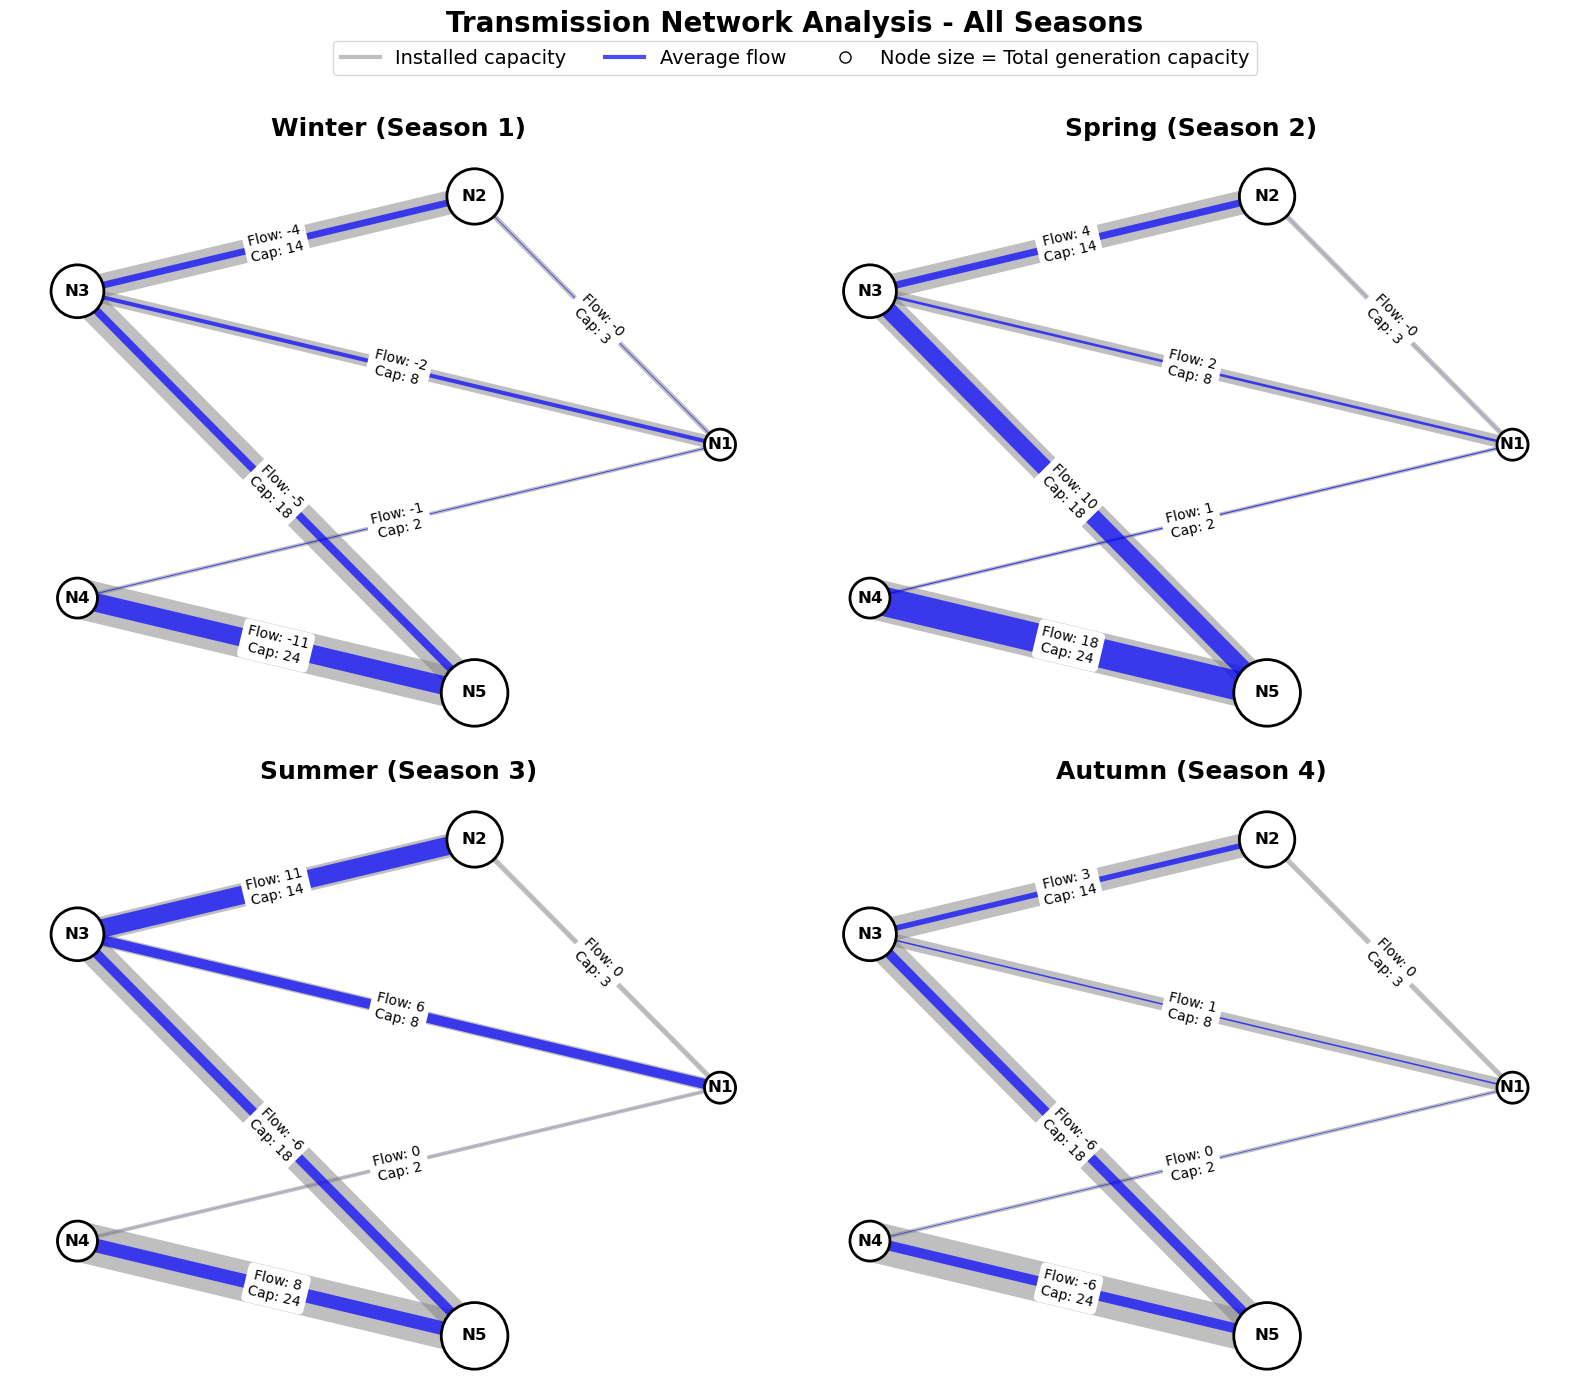

In [ ]:
# NetworkX plot: transmission network for all seasons
node_labels = ["N1", "N2", "N3", "N4", "N5"]
season_labels = ["Winter", "Spring", "Summer", "Autumn"]

scale_factor = 1.2

# Calculate total generation capacity per node (sum across all technologies)
total_gen_cap = np.sum(sol_p_max_det + GCN, axis=0)  # shape: (5,)
# Scale node sizes: min=500, max=2000
min_cap, max_cap = total_gen_cap.min(), total_gen_cap.max()
node_sizes = 500 + (total_gen_cap - min_cap) / (max_cap - min_cap) * 1500 * scale_factor

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for season_idx, season in enumerate(S):
    # Average transmission flow per line in chosen season (MWh)
    avg_flow = sol_f[:, :, season-1].mean(axis=0)  # shape: (len(L),)

    # Build graph with all potential lines
    G = nx.Graph()
    for n in N:
        G.add_node(n)

    # Add all potential edges (even those with zero capacity)
    for i, l in enumerate(L):
        cap_new = sol_f_max_det[i]
        flow_avg = avg_flow[i]
        G.add_edge(l[0], l[1], capacity=cap_new, flow=flow_avg)

    pos = nx.circular_layout(G)
    ax = axes[season_idx]
    
    # Draw network on specific axis
    plt.sca(ax)

    # Node styling with capacity-based sizes
    nx.draw_networkx_nodes(G, pos, node_color="white", node_size=[node_sizes[n-1] for n in N], 
                           edgecolors="black", linewidths=2, ax=ax)
    nx.draw_networkx_labels(G, pos, labels={n: node_labels[n-1] for n in N}, font_size=12, font_weight="bold", ax=ax)

    # Get edges with installed capacity
    edges_with_capacity = [(u, v) for u, v in G.edges() if G[u][v]["capacity"] > 1e-6]

    if edges_with_capacity:
        
       
        # 1. Draw grey edges with width = installed capacity
        
        cap_widths = [G[u][v]["capacity"] * scale_factor for u, v in edges_with_capacity]
        nx.draw_networkx_edges(G, pos, edgelist=edges_with_capacity, width=cap_widths, 
                              edge_color="grey", alpha=0.5, ax=ax)
        
        # 2. Draw blue edges with width = average flow
        flow_widths = [G[u][v]["flow"] *scale_factor for u, v in edges_with_capacity]
        nx.draw_networkx_edges(G, pos, edgelist=edges_with_capacity, width=flow_widths, 
                             edge_color="blue", alpha=0.7, ax=ax)
   
    # Edge labels: only for edges with installed capacity
    edge_labels = {}
    for u, v in edges_with_capacity:
        cap = G[u][v]["capacity"]
        flow = G[u][v]["flow"]
        edge_labels[(u, v)] = f"Flow: {flow:.0f}\nCap: {cap:.0f}"

    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10, ax=ax)

    ax.set_title(f"{season_labels[season-1]} (Season {season})", fontsize=18, fontweight="bold")
    ax.axis("off")

# Add legend to figure
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color="grey", lw=3, alpha=0.5, label="Installed capacity"),
    Line2D([0], [0], color="blue", lw=3, alpha=0.7, label="Average flow"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markeredgecolor='black', 
           markersize=8, label="Node size = Total generation capacity"),
]
fig.legend(handles=legend_handles, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.98), frameon=True, fontsize=14)

plt.suptitle("Transmission Network Analysis - All Seasons", fontsize=20, fontweight="bold", y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

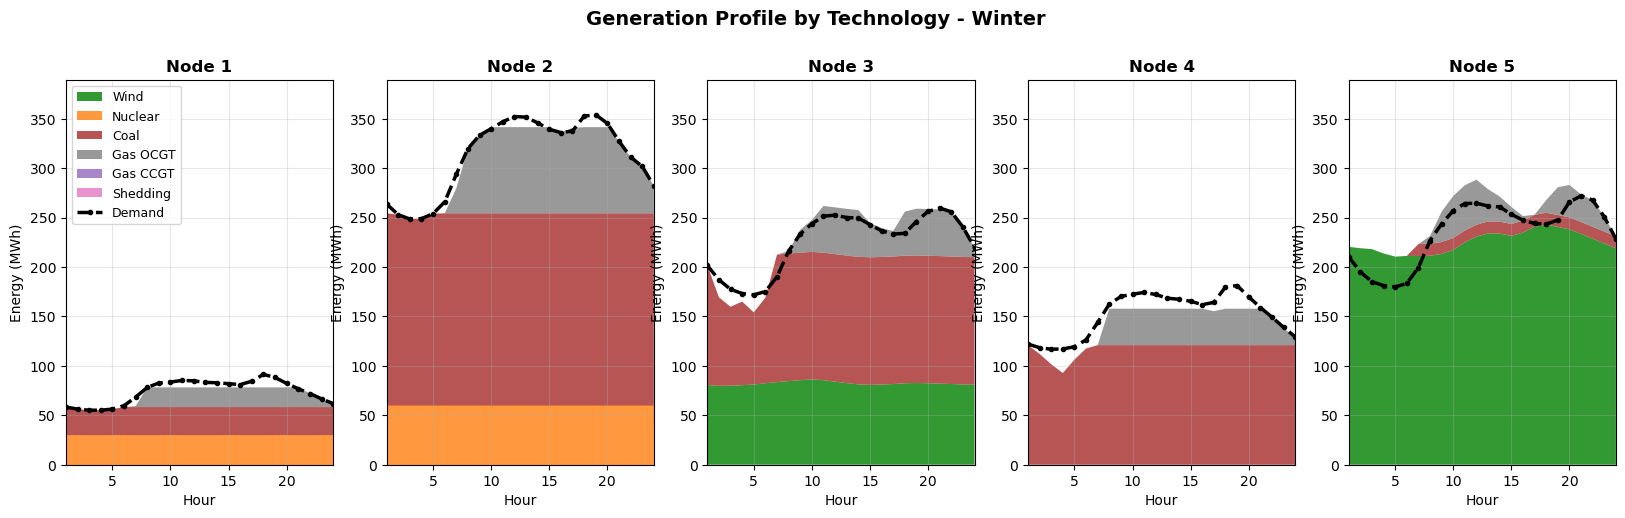

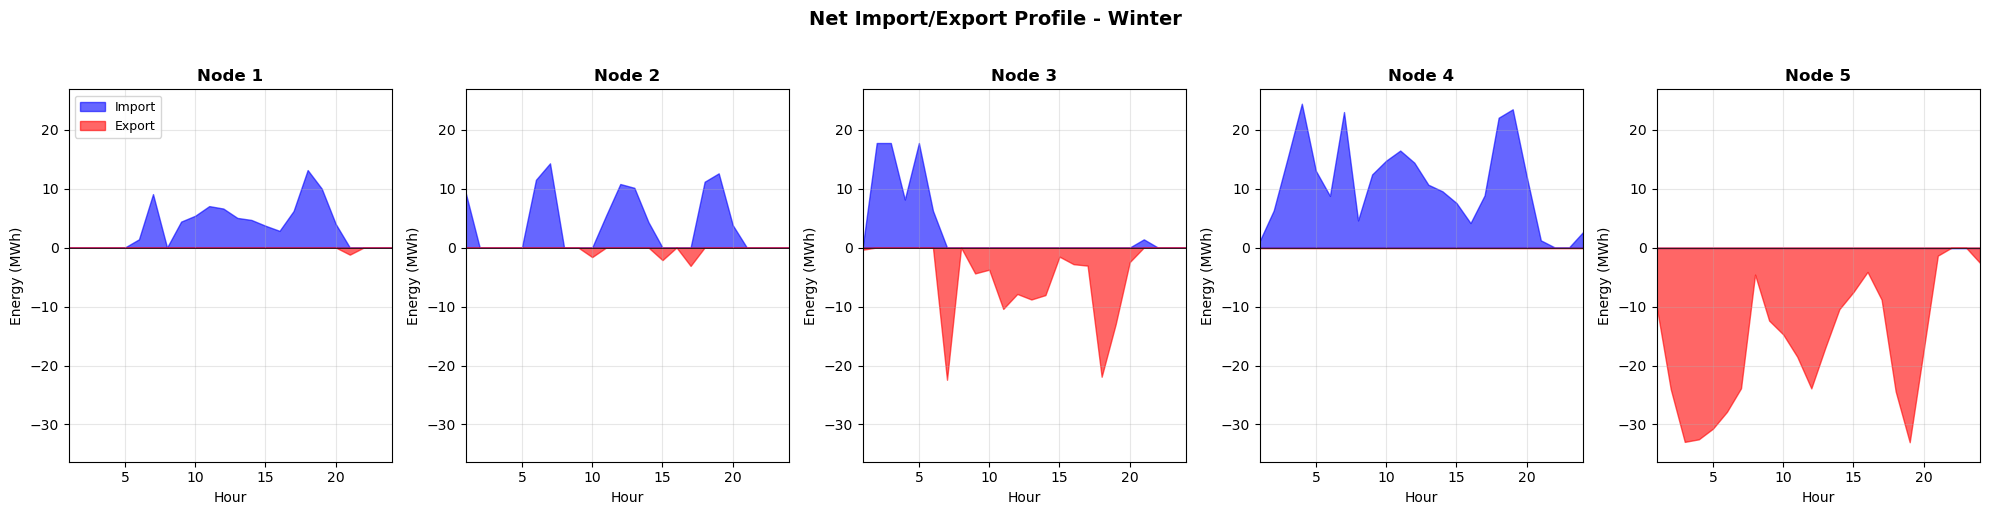

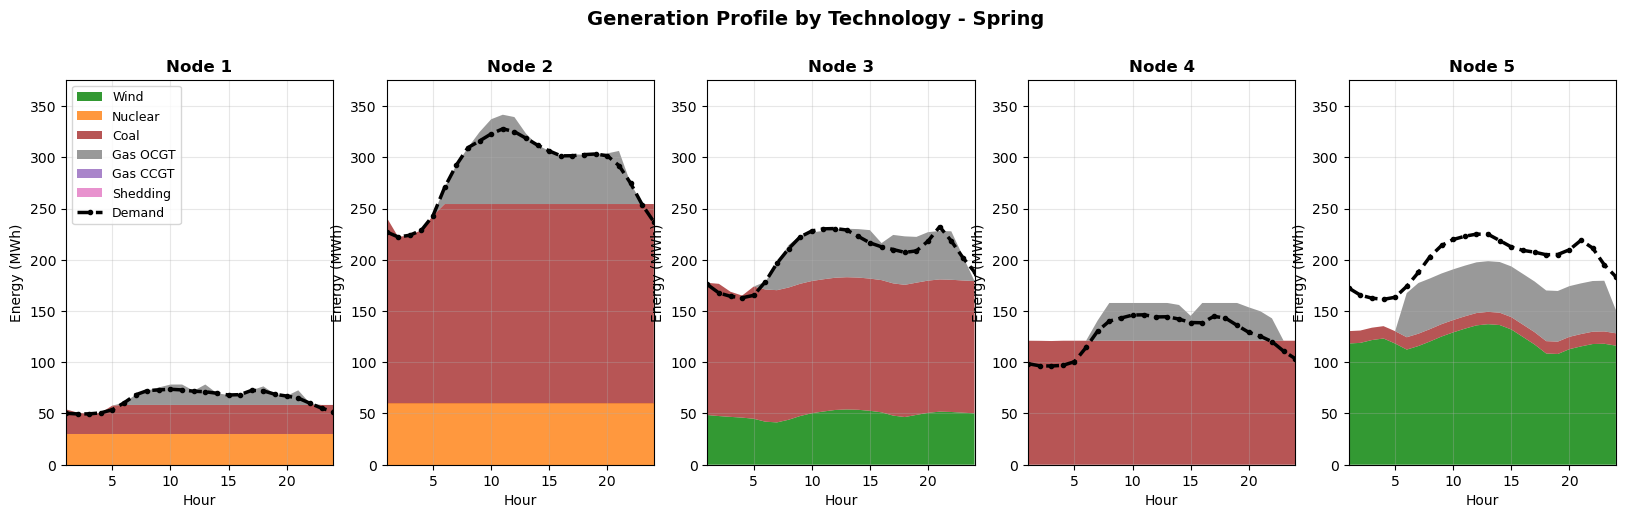

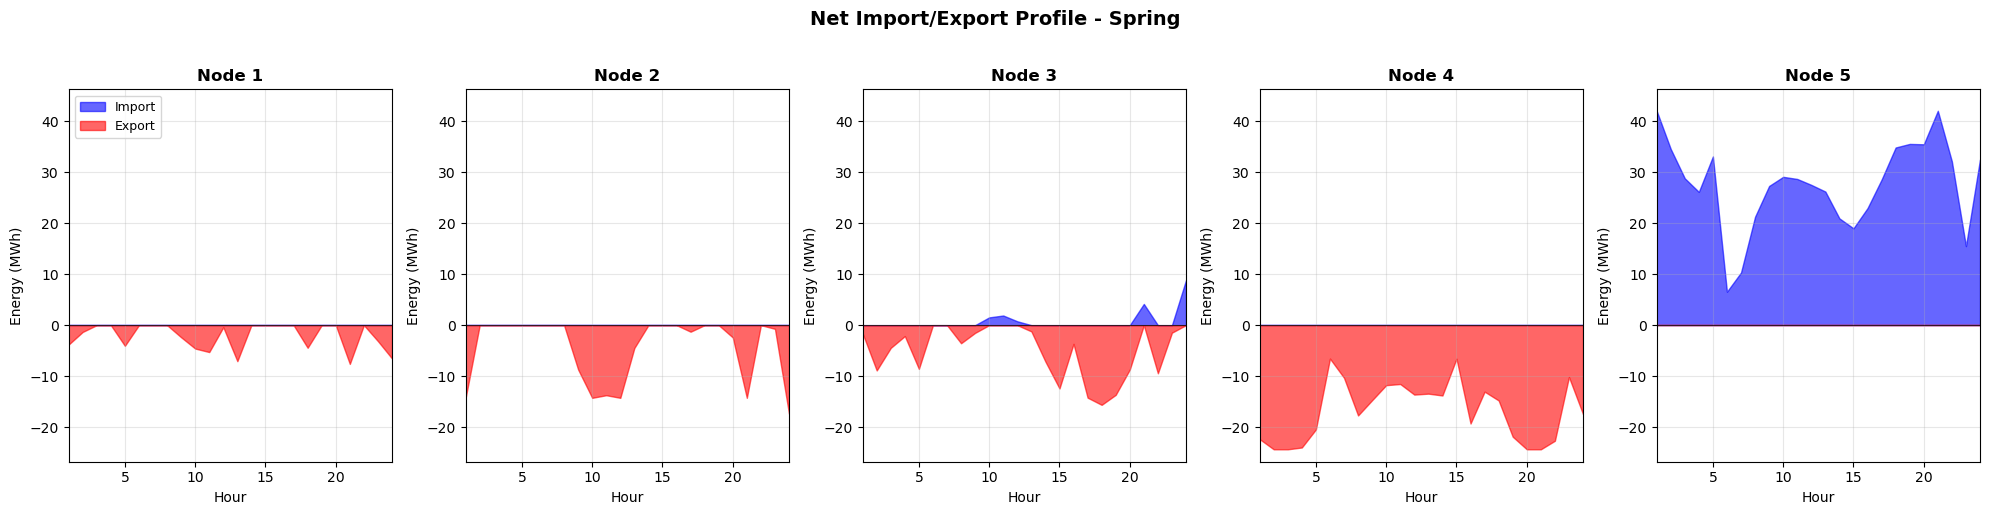

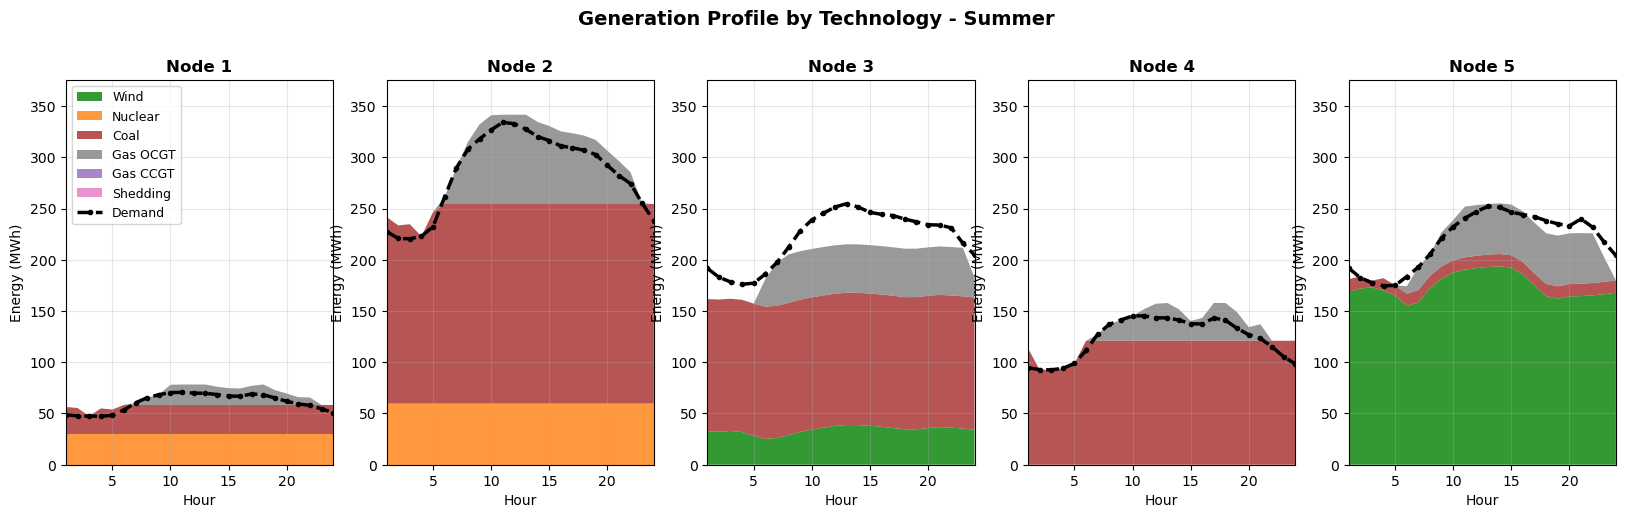

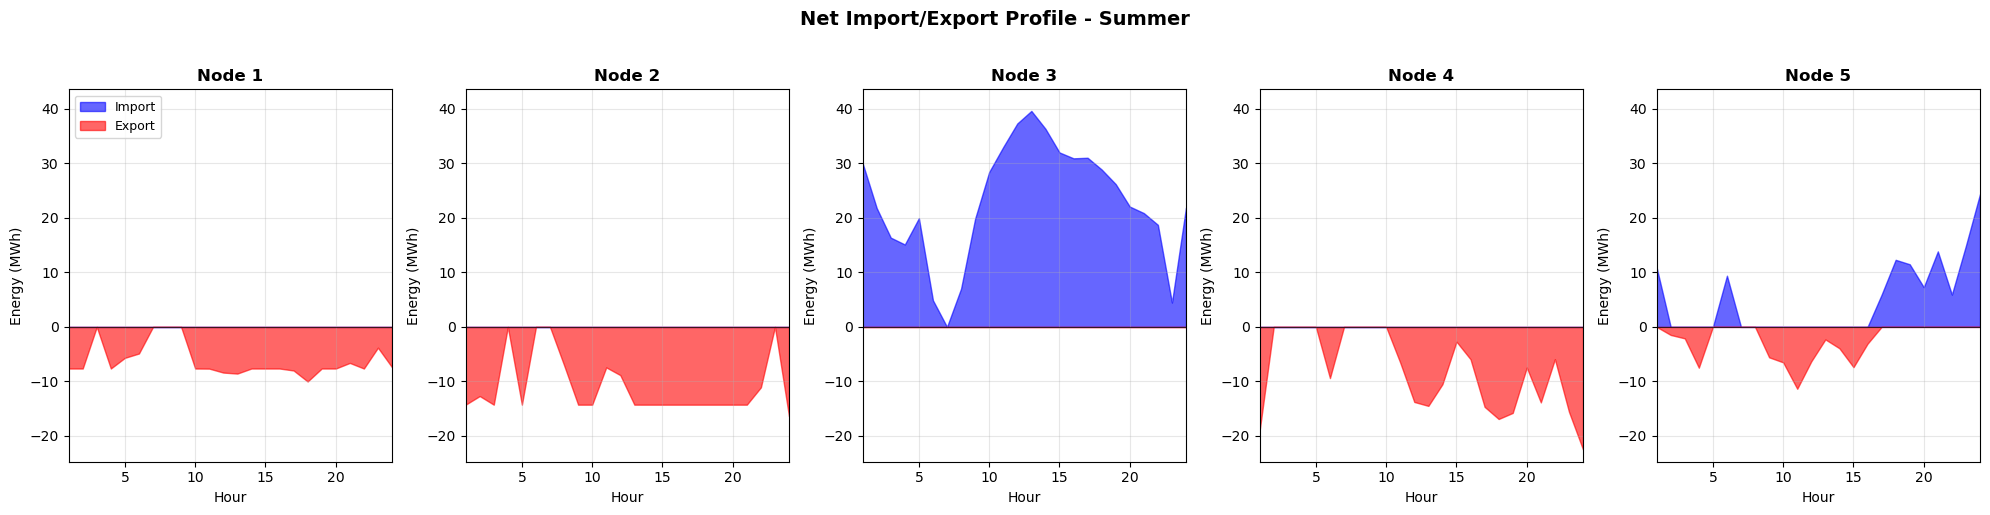

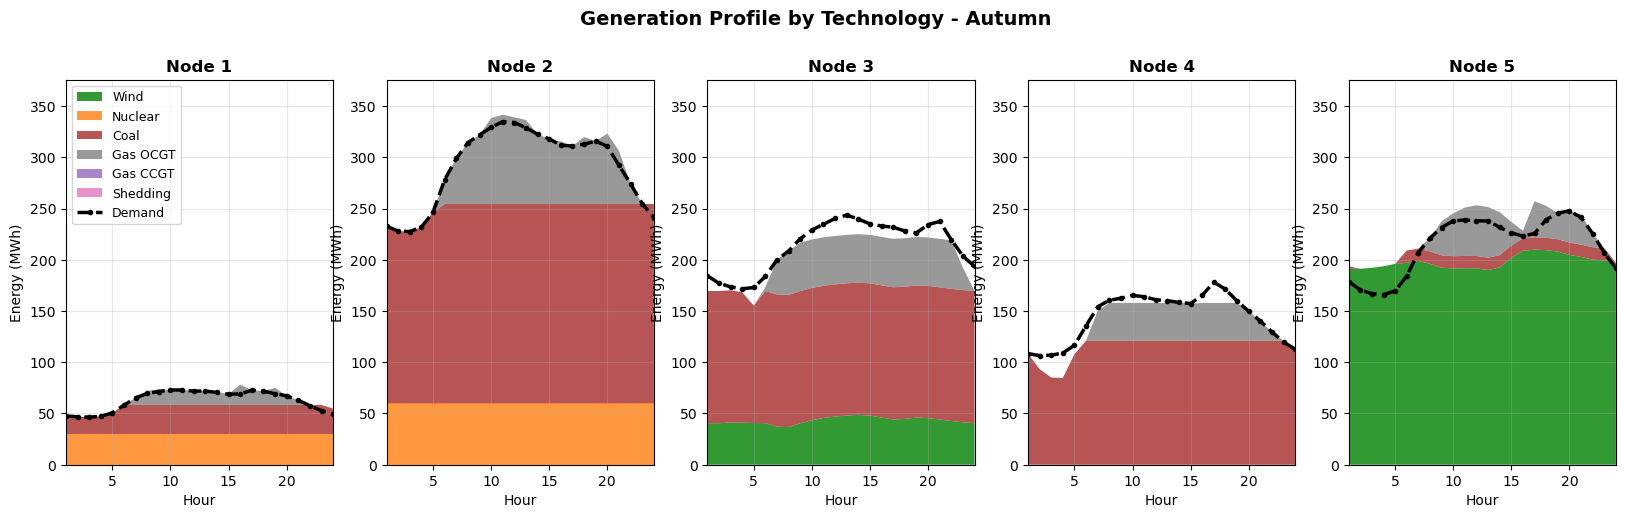

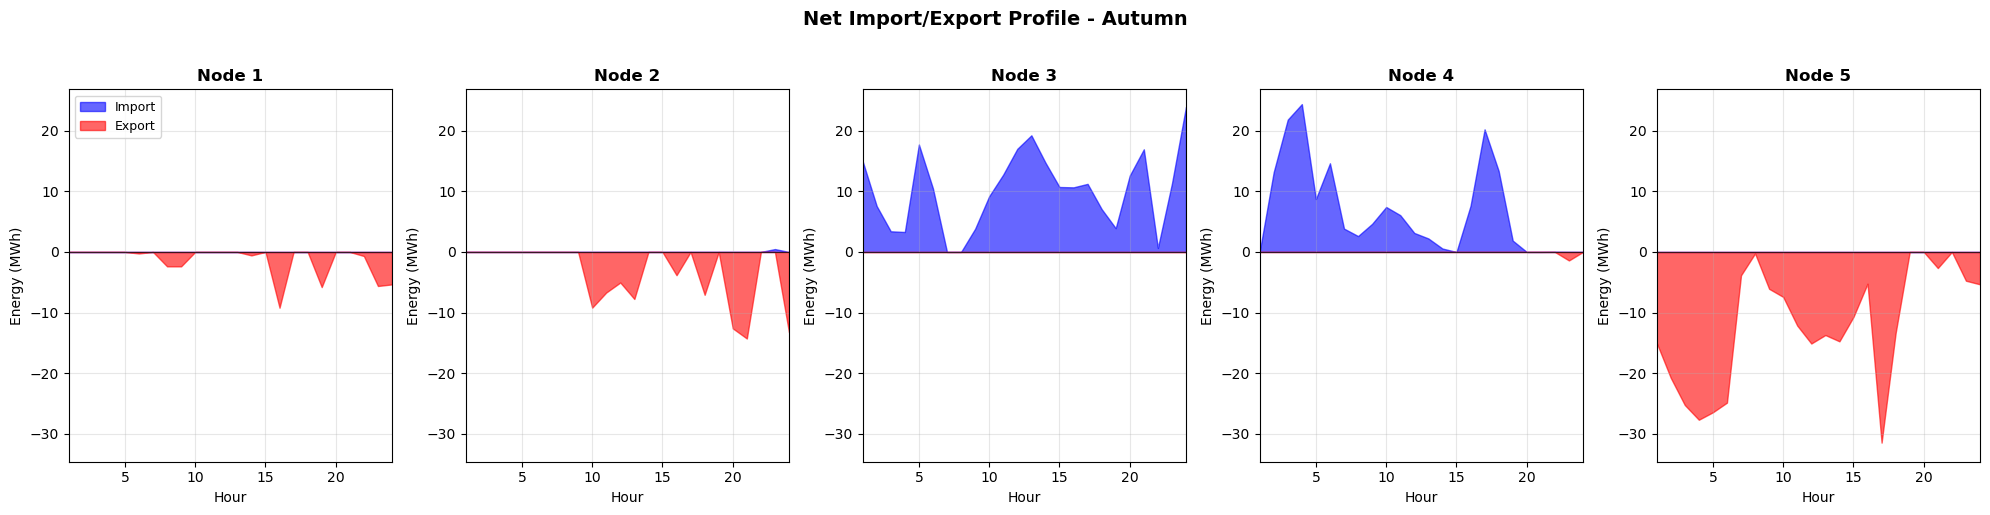

In [62]:
for i in [0,1,2,3]:
    # Stacked area chart: Generation by technology for one season, all nodes
    season_idx = i  # Winter (change to 1, 2, or 3 for Spring, Summer, Autumn)
    season_labels = ["Winter", "Spring", "Summer", "Autumn"]
    tech_labels = ["Wind", "Nuclear", "Coal", "Gas OCGT", "Gas CCGT", "Shedding"]
    tech_colors = ["green", "#ff7f0e", "brown", "grey", "#9467bd", "#e377c2"]

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # First pass: calculate max y-value across all nodes
    max_y = 0

    for node_idx, node in enumerate(N):
        # Extract generation for this node and season across all hours
        gen_by_tech = np.zeros((len(T) + 1, len(H)))  # +1 for shedding
        for t_idx, t in enumerate(T):
            for h_idx, h in enumerate(H):
                gen_by_tech[t_idx, h_idx] = sol_p[t_idx, h_idx, node_idx, season_idx]
        
        # Add shedding as the last layer
        for h_idx, h in enumerate(H):
            gen_by_tech[len(T), h_idx] = sol_q[h_idx, node_idx, season_idx]
        
        # Extract demand for this node and season
        demand_profile = D[node_idx, :, season_idx]
        
        # Calculate total generation + shedding per hour
        total_gen = gen_by_tech.sum(axis=0)
        
        # Update max_y considering both generation and demand
        max_y = max(max_y, np.max(total_gen), np.max(demand_profile))

    # Second pass: plot with harmonized y-axis
    for node_idx, node in enumerate(N):
        # Extract generation for this node and season across all hours
        gen_by_tech = np.zeros((len(T) + 1, len(H)))  # +1 for shedding
        for t_idx, t in enumerate(T):
            for h_idx, h in enumerate(H):
                gen_by_tech[t_idx, h_idx] = sol_p[t_idx, h_idx, node_idx, season_idx]
        
        # Add shedding as the last layer
        for h_idx, h in enumerate(H):
            gen_by_tech[len(T), h_idx] = sol_q[h_idx, node_idx, season_idx]
        
        # Extract demand for this node and season
        demand_profile = D[node_idx, :, season_idx]
        
        ax = axes[node_idx]
        hours = np.arange(1, len(H) + 1)
        
        # Plot stacked area chart (generation + shedding)
        ax.stackplot(hours, gen_by_tech, labels=tech_labels, colors=tech_colors, alpha=0.8)
        
        # Plot demand as a line
        ax.plot(hours, demand_profile, color='black', linewidth=2.5, label='Demand', linestyle='--', marker='o', markersize=3)
        
        ax.set_title(f"Node {node}", fontsize=12, fontweight="bold")
        ax.set_xlabel("Hour", fontsize=10)
        ax.set_ylabel("Energy (MWh)", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(1, len(H))
        
        # Apply harmonized y-axis limits to all subplots
        ax.set_ylim(0, max_y * 1.1)
        
        # Only add legend to first subplot
        if node_idx == 0:
            ax.legend(loc="upper left", fontsize=9)

    plt.suptitle(f"Generation Profile by Technology - {season_labels[season_idx]}", 
                fontsize=14, fontweight="bold", y=1.02)

    ##################################################################################################

    # Net import/export profile per node (stacked area chart)
    season_idx = i  # Winter (change to 1, 2, or 3 for Spring, Summer, Autumn)
    season_labels = ["Winter", "Spring", "Summer", "Autumn"]

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # First pass: calculate max/min values for all nodes
    max_import = 0
    max_export = 0

    for node_idx, node in enumerate(N):
        net_flow = np.zeros(len(H))
        
        for h_idx, h in enumerate(H):
            net_inflow = 0
            for l_idx, l in enumerate(L):
                i, j = l
                if node == i:
                    net_inflow -= sol_f[h_idx, l_idx, season_idx]
                elif node == j:
                    net_inflow += sol_f[h_idx, l_idx, season_idx]
            net_flow[h_idx] = net_inflow
        
        imports = np.maximum(net_flow, 0)
        exports = np.minimum(net_flow, 0)
        
        max_import = max(max_import, np.max(imports))
        max_export = min(max_export, np.min(exports))

    # Second pass: plot with harmonized axes
    for node_idx, node in enumerate(N):
        net_flow = np.zeros(len(H))
        
        for h_idx, h in enumerate(H):
            net_inflow = 0
            for l_idx, l in enumerate(L):
                i, j = l
                if node == i:
                    net_inflow -= sol_f[h_idx, l_idx, season_idx]
                elif node == j:
                    net_inflow += sol_f[h_idx, l_idx, season_idx]
            net_flow[h_idx] = net_inflow
        
        ax = axes[node_idx]
        hours = np.arange(1, len(H) + 1)
        
        imports = np.maximum(net_flow, 0)
        exports = np.minimum(net_flow, 0)
        
        ax.fill_between(hours, 0, imports, label='Import', color='blue', alpha=0.6)
        ax.fill_between(hours, 0, exports, label='Export', color='red', alpha=0.6)
        ax.axhline(y=0, color='black', linewidth=0.5)
        
        ax.set_title(f"Node {node}", fontsize=12, fontweight="bold")
        ax.set_xlabel("Hour", fontsize=10)
        ax.set_ylabel("Energy (MWh)", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(1, len(H))
        
        # Apply harmonized y-axis limits to all subplots
        ax.set_ylim(max_export * 1.1, max_import * 1.1)
        
        if node_idx == 0:
            ax.legend(loc="upper left", fontsize=9)

    plt.suptitle(f"Net Import/Export Profile - {season_labels[season_idx]}", 
                fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

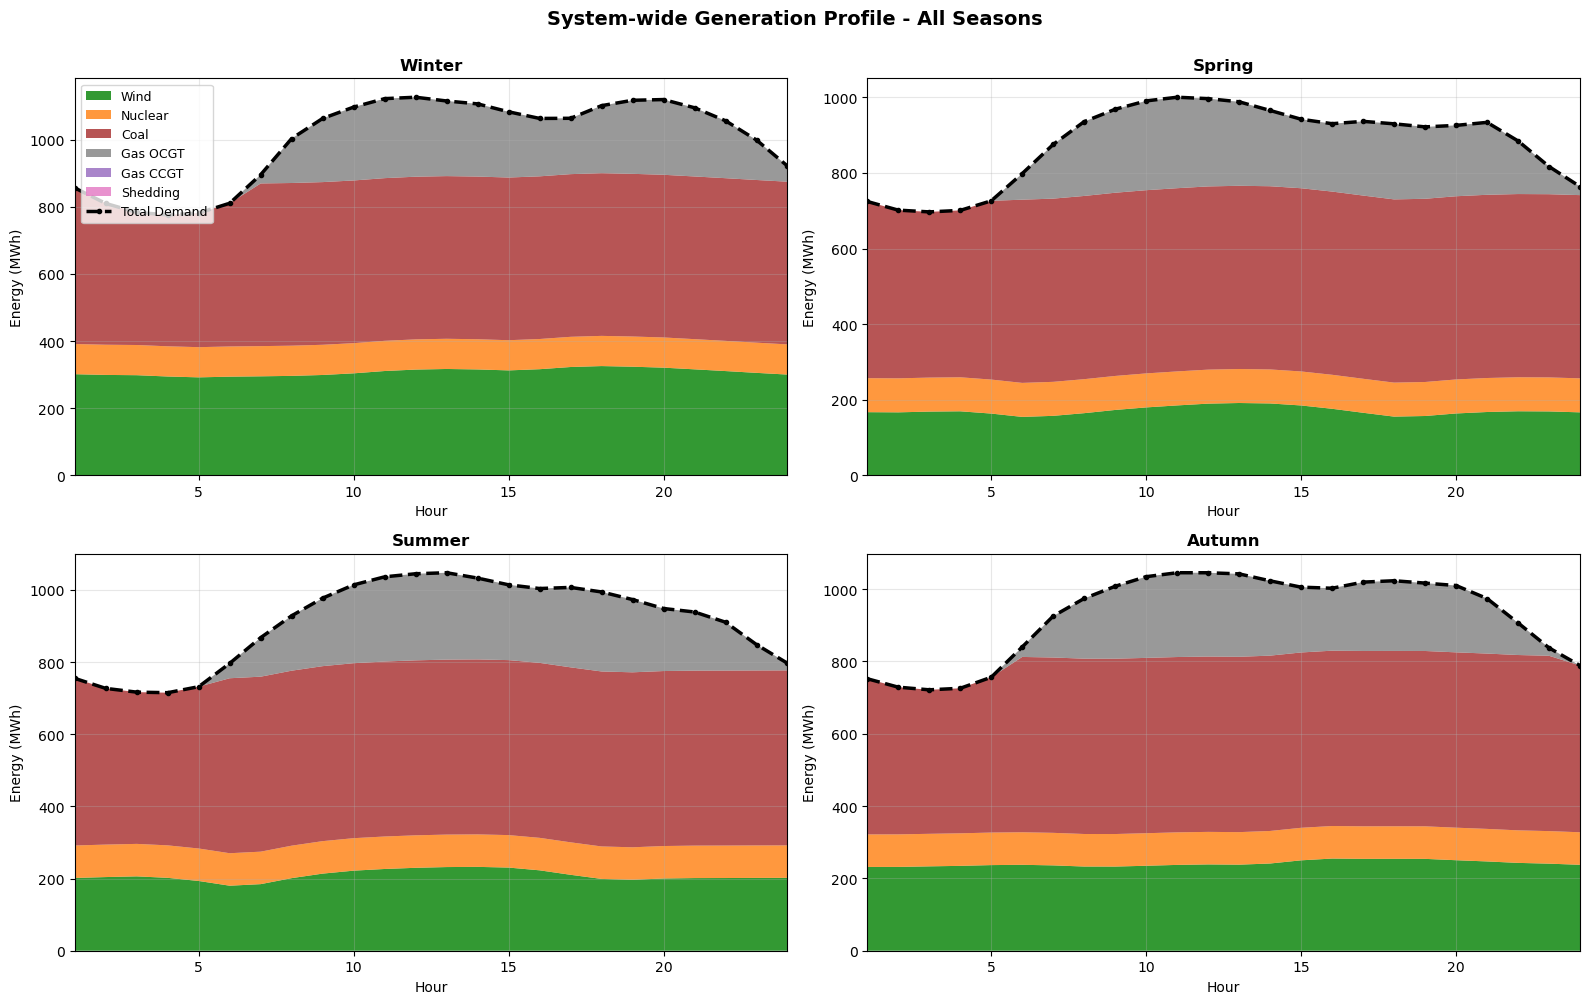

In [64]:
# System-wide generation profile (all seasons in 2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

season_labels = ["Winter", "Spring", "Summer", "Autumn"]
tech_labels = ["Wind", "Nuclear", "Coal", "Gas OCGT", "Gas CCGT", "Shedding"]
tech_colors = ["green", "#ff7f0e", "brown", "grey", "#9467bd", "#e377c2"]

for season_idx, season in enumerate(S):
    # Extract total generation for this season across all hours and nodes
    gen_by_tech_total = np.zeros((len(T) + 1, len(H)))  # +1 for shedding
    for t_idx, t in enumerate(T):
        for h_idx, h in enumerate(H):
            gen_by_tech_total[t_idx, h_idx] = np.sum(sol_p[t_idx, h_idx, :, season_idx])
    
    # Add total shedding as the last layer
    for h_idx, h in enumerate(H):
        gen_by_tech_total[len(T), h_idx] = np.sum(sol_q[h_idx, :, season_idx])
    
    # Extract total demand for this season
    demand_total = np.sum(D[:, :, season_idx], axis=0)
    
    hours = np.arange(1, len(H) + 1)
    ax = axes[season_idx]
    
    # Plot stacked area chart (generation + shedding)
    ax.stackplot(hours, gen_by_tech_total, labels=tech_labels, colors=tech_colors, alpha=0.8)
    
    # Plot total demand as a line
    ax.plot(hours, demand_total, color='black', linewidth=2.5, label='Total Demand', 
            linestyle='--', marker='o', markersize=3)
    
    ax.set_title(f"{season_labels[season_idx]}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Hour", fontsize=10)
    ax.set_ylabel("Energy (MWh)", fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, len(H))
    
    # Add legend only to first subplot
    if season_idx == 0:
        ax.legend(loc="upper left", fontsize=9)

plt.suptitle("System-wide Generation Profile - All Seasons", fontsize=14, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

## Task 2
The extended model

In [24]:
# Modified deterministic (node RES + ramping)
RES_node = np.array([0.45, 0.45, 0.60, 0.70, 0.70])                 # Renewable energy requirement per node [% of energy production]
ramp_limit = 0.2                                                    # Relative ramping variation allowed [% of energy production]  
def build_det_model_pulp_mod():
    m = pulp.LpProblem("GTEP_Deterministic_Mod", pulp.LpMinimize)
    p     = pulp.LpVariable.dicts("p",     (T, H, N, S), lowBound=0)        # Generation level in each hour by t [MWh]
    p_max = pulp.LpVariable.dicts("p_max", (T, N),        lowBound=0)       # Additional generation capac. of t [MW]
    q     = pulp.LpVariable.dicts("q",     (H, N, S),     lowBound=0)       # Energy shedding in h [MWh]
    f     = pulp.LpVariable.dicts("f",     (H, L, S),     lowBound=None)    # Transmission flow in each hour by t [MWh]
    f_abs = pulp.LpVariable.dicts("f_abs", (H, L, S),     lowBound=0)       # Auxiliary variable for calculating |f[h,l,s]|
    f_max = pulp.LpVariable.dicts("f_max", (L,),          lowBound=0)       # Additional transmission capac. of l [MW]

    # 1) Generation investment (annualised capex) + fixed O&M on built capacity
    gen_invest = pulp.lpSum(
        (K[t-1] + KA[t-1]) * p_max[t][n]
        for t in T for n in N
    )

    # 2) Transmission investment (annualised) + fixed O&M
    trans_invest = pulp.lpSum(
        (KT_per_line[line_index[l]] + KAT) * f_max[l]
        for l in L
    )

    # 3) Generation operational cost (weighted by number of days represented by each season)
    gen_oper = pulp.lpSum(
        season_days(s) * CO[t-1] * p[t][h][n][s]
        for t in T for h in H for n in N for s in S
    )

    # 4) Transmission operational cost on |flow|
    trans_oper = pulp.lpSum(
        season_days(s) * COT * f_abs[h][l][s]
        for h in H for l in L for s in S
    )

    # 5) Shedding cost
    shed_cost = pulp.lpSum(
        season_days(s) * CS * q[h][n][s]
        for h in H for n in N for s in S
    )

    m += gen_invest + trans_invest + gen_oper + trans_oper + shed_cost


    ## Constraints
    
       # Helper: incidence sign for line l=(i,j)
    # Convention: f[h,(i,j),s] > 0 means flow from i -> j
    def inc(n, l):
        i, j = l
        if n == i:
            return -1
        elif n == j:
            return +1
        else:
            return 0


    # 1) Energy balance per node/hour/season:
    # sum_t p + net_inflow = demand - shedding
    for h in H:
        for n in N:
            for s in S:
                m += (
                    pulp.lpSum(p[t][h][n][s] for t in T)
                    + pulp.lpSum(inc(n, l) * f[h][l][s] for l in L)
                    == D_val(n, h, s) - q[h][n][s]
                ), f"bal_{h}_{n}_{s}"


    # 2) Wind generation availability constraint:
    # p_wind <= (existing_wind + new_wind) * availability
    for h in H:
        for n in N:
            for s in S:
                m += (
                    p[1][h][n][s]
                    <= (GCN[0, n-1] + p_max[1][n]) * W_val(n, h, s)
                )


    # 3) Non-renewable generation capacity constraints:
    # p_t <= existing_t + new_t   for t = 2..5
    for t in [2, 3, 4, 5]:
        for h in H:
            for n in N:
                for s in S:
                    m += (
                        p[t][h][n][s]
                        <= GCN[t-1, n-1] + p_max[t][n]
                    )


    # 4) Minimum renewable energy share (system-wide):
    # total_wind >= RES * total_generation
    total_ren = pulp.lpSum(
        season_days(s) * p[1][h][n][s]
        for h in H for n in N for s in S
    )

    total_gen = pulp.lpSum(
        season_days(s) * pulp.lpSum(p[t][h][n][s] for t in T)
        for h in H for n in N for s in S
    )

    m += total_ren >= RES * total_gen


    # 5) Shedding limit: q <= ShC * demand
    for h in H:
        for n in N:
            for s in S:
                m += q[h][n][s] <= ShC * D_val(n, h, s)


    # 6) Transmission capacity bounds: -cap <= f <= cap
    # Here cap = f_max[l] (no existing capacity given in skeleton)
    # 7) Linearisation for absolute value: f_abs >= f and f_abs >= -f
    for h in H:
        for l in L:
            for s in S:
                m += f[h][l][s] <= f_max[l]
                m += f[h][l][s] >= -f_max[l]
                m += f_abs[h][l][s] >= f[h][l][s]
                m += f_abs[h][l][s] >= -f[h][l][s]


    return m, (p, p_max, q, f, f_abs, f_max)
    
       

m_det2, (p2, p_max2, q2, f2, f_abs2, f_max2) = build_det_model_pulp_mod()
solver = pulp.PULP_CBC_CMD(msg=False, mip=False)
m_det2.solve(solver)

sol_p_max_det2 = np.zeros((len(T), len(N)))
for t in T:
    for n in N:
        sol_p_max_det2[t-1, n-1] = pulp.value(p_max2[t][n])

sol_f_max_det2 = np.zeros(len(L))
for i,l in enumerate(L):
    sol_f_max_det2[i] = pulp.value(f_max2[l])

lam2=np.zeros((len(H),len(N),len(S)))
for h in H:
    for n in N:
        for s in S:
            lam2[h-1,n-1,s-1]=m_det2.constraints[f"bal2_{h}_{n}_{s}"].pi

dual_vals2=lam2.flatten()


KeyError: 'bal2_1_1_1'

We replicate below some of the analyses of the previus task. Feel free to come up with your own to analyse the results and discuss the main differences between the models in tasks 1 and 2.

In [ ]:
print("Capacities (modified, Tech x Node):")
print(np.round(sol_p_max_det2, 2))

In [ ]:
print("\nTransmission capacities (modified):")
print(np.round(sol_f_max_det2, 2))

In [ ]:
print("P\nHourly price statistics:")
print(f"- Mean price per MWh: {dual_vals2.mean():.2f}")
print(f"- Standard deviation: {dual_vals2.std():.2f}")
print(f"- Max price per MWh: {dual_vals2.max():.2f}")
print(f"- Min price per MWh: {dual_vals2.min():.2f}")

In [ ]:
sol_p2 = np.zeros((len(T), len(H), len(N), len(S)))
for t in T:
    for h in H:
        for n in N:
            for s in S:
                sol_p2[t-1,h-1,n-1,s-1] = pulp.value(p2[t][h][n][s])

winter = 0   
summer = 2   
node   = 2   



A_full = np.round(sol_p2[:,:,:,summer] - sol_p2[:,:,:,winter], 2).sum(axis=1)  

print("\nDispatch difference in the deterministic model for N3 between Winter and Summer was: ")
print(np.round(A_full,2))

In [ ]:
sol_f_det2 = np.zeros((len(H), len(L), len(S)))

for hi, h in enumerate(H):
    for li, l in enumerate(L):
        for si, s in enumerate(S):
            sol_f_det2[hi, li, si] = pulp.value(f2[h][l][s])
flows_line10 = np.sum(np.round(sol_f_det2[:, 9, :], 2))

print("\nTransmission flows installed in the deterministic model (Line 10):")
print(round(flows_line10,2))

In [ ]:
A = np.round(sol_f_det2,2).sum(axis=0)   

print("\nTrade profiles:")
np.set_printoptions(suppress=True, precision=4)  
print(A)

## Task 3
The stochastic model

In [ ]:
# Stochastic model (expected costs)
# First we need to create the set representing the scenarios, augment the parameters with wind and demand data, and finally provide the probability of each scenario.

SC = [1,2,3]    # Sc 1="Pessimistic" (min. value); 2="Expected" (mean value); 3="Optimistic" (max. value)

## Augmenting wind and demand data for the stochastic model
D_sto = np.zeros((5,24,4,3))    # Dimensions: (node, hour, season, scenario)
W_sto = np.zeros((5,24,4,3))  
_demand_raw, _wind_raw = read_input_data("Data")
for i in range(5):      # Node
    for j in range(4):  # Season

        ## Pessimistic
        D_sto[i,:,j,0] = max_load[i] * _demand_raw[i,:,j,2]
        W_sto[i,:,j,0] = _wind_raw[i,:,j,0]

        ## Expected
        D_sto[i,:,j,1] = max_load[i] * _demand_raw[i,:,j,1]
        W_sto[i,:,j,1] = _wind_raw[i,:,j,1]

        ## Optimistic
        D_sto[i,:,j,2] = max_load[i] * _demand_raw[i,:,j,0]
        W_sto[i,:,j,2] = _wind_raw[i,:,j,2]

## Probability distribution for scenarios (1 - pessimist, 2 - average, 3 - optimistic)
Pr = np.array([0.25,0.5,0.25])

def D_s(n,h,s,sc): return D_sto[n-1, h-1, s-1, sc-1]
def W_s(n,h,s,sc): return W_sto[n-1, h-1, s-1, sc-1]




In [ ]:
def build_sto_model_pulp(Pr_vec):
    m = pulp.LpProblem("GTEP_Stochastic", pulp.LpMinimize)
    p     = pulp.LpVariable.dicts("p",     (T, H, N, S, SC), lowBound=0)        # Generation level in each hour by t [MW]
    p_max = pulp.LpVariable.dicts("p_max", (T, N),           lowBound=0)        # Additional generation capac. of t [MW]
    q     = pulp.LpVariable.dicts("q",     (H, N, S, SC),    lowBound=0)        # Energy shedding in h [MWh]
    f     = pulp.LpVariable.dicts("f",     (H, L, S, SC),    lowBound=None)     # Transmission flow in each hour by t [MWh]
    f_abs = pulp.LpVariable.dicts("f_abs", (H, L, S, SC),    lowBound=0)        # Auxiliary variable for calculating |f[h,l,s]|
    f_max = pulp.LpVariable.dicts("f_max", (L,),             lowBound=0)        # Additional transmission capac. of t [MW]


    ## Objective function
    # TODO
    m += # TODO


    ## Constraints

    ## 1) Energy balance
    for h in H:
        for n in N:
            for s in S:
                for sc in SC:
                    # TODO keep the following after the constraint: , f"bal_sto_{h}_{n}_{s}_{sc}"


    ## 2) Wind generation capacity
    for h in H:
        for n in N:
            for s in S:
                for sc in SC:
                    # TODO

    ## 3) Nonrenewable generation capacity
    for t in [2,3,4,5]:
        for h in H:
            for n in N:
                for s in S:
                    for sc in SC:
                        # TODO

    ## 4) Minimum renewable energy generation
    for sc in SC:
        # TODO

    ## 5) Shedding cap
    for h in H:
        for n in N:
            for s in S:
                for sc in SC:
                    # TODO

    ## 6) Transmission cap and absolute value of f[h][l][s][sc]
    for h in H:
        for l in L:
            for s in S:
                for sc in SC:
                    # TODO

    return m, (p, p_max, q, f, f_abs, f_max)

m_sto, (ps, pmaxs, qs, fs, fabs_s, fmaxs) = build_sto_model_pulp(Pr)
m_sto.solve(solver)

sol_p_max_sto = np.zeros((len(T), len(N)))
for t in T:
    for n in N:
        sol_p_max_sto[t-1, n-1] = pulp.value(pmaxs[t][n])

sol_f_max_sto = np.zeros(len(L))
for i,l in enumerate(L):
    sol_f_max_sto[i] = pulp.value(fmaxs[l])
    
lam_sto = np.zeros((len(H), len(N), len(S), len(SC)))

for h in H:
    for n in N:
        for s in S:
            for sc in SC:
                cname = f"bal_sto_{h}_{n}_{s}_{sc}"
                lam_sto[h-1,n-1,s-1,sc-1] = m_sto.constraints[cname].pi

prices_all = lam_sto.flatten()

sol_q_sto = np.zeros((len(H), len(N), len(S), len(SC)))
for hi,h in enumerate(H):
    for ni,n in enumerate(N):
        for si,s in enumerate(S):
            for sci,sc in enumerate(SC):
                sol_q_sto[hi,ni,si,sci] = pulp.value(qs[h][n][s][sc])
                
shortages = sol_q_sto[sol_q_sto > 0]              
shortages_rounded = np.round(shortages, 2)

New_Pr = np.array([0.60, 0.30, 0.10])
m_sto2, (ps2, pmaxs2, qs2, fs2, fabs2, fmaxs2) = build_sto_model_pulp(New_Pr)
m_sto2.solve(solver)

sol_p_max_sto2 = np.zeros((len(T), len(N)))
for t in T:
    for n in N:
        sol_p_max_sto2[t-1, n-1] = pulp.value(pmaxs2[t][n])


Here are once more suggestions for comparing the model with the deterministic version

"What was the generation capacity installed per technology per node? What was the transmission capacity installed?"

In [ ]:
print("Capacities installed (stochastic):")
print(np.round(sol_p_max_sto, 2))

In [ ]:
print("\nDiff vs deterministic (generation caps):")
print(np.round(sol_p_max_sto - sol_p_max_det, 2))

In [ ]:
print("\nDiff vs deterministic (transmission caps):")
print(np.round(sol_f_max_sto - sol_f_max_det, 2))

In [ ]:
print("\nOccurrence of shortage:")
print(shortages_rounded)

In [ ]:
# Probability sensitivity
print("New capacities (stochastic, New_Pr):")
print(np.round(sol_p_max_sto2, 2))
print("\nDifferences vs baseline stochastic:")
print(np.round(sol_p_max_sto2 - sol_p_max_sto, 2))


In [ ]:
print("P\nHourly price statistics:")
print(f"- Mean price per MWh:  {prices_all.mean():.2f}")
print(f"- Standard deviation: {prices_all.std():.2f}")
print(f"- Max price per MWh: {prices_all.max():.2f}")
print(f"- Min price per MWh:: {prices_all.min():.2f}")

# Expected nodal price (prob. weighted)
exp_price_node = (lam_sto * Pr.reshape(1,1,1,-1)).sum(axis=3).mean(axis=(0,2))
print("\nExpected nodal price by node:", np.round(exp_price_node,2))